# Урок 9. Python применение продвинутых методов
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

Mobile Games AB Testing with Cookie Ca  
  
About this file  
The data we have is from 90,189 players that installed the game while the AB-test was running.
When a player installed the game, he or she was randomly assigned to eithe    

Об этом файле  
У нас есть данные от 90 189 игроков, которые установили игру во время проведения AB-теста.
Когда игрок устанавливал игру, он или она были случайным образом назначены на любую из них.    

<img src="about file.jpg" >  r.ts

*__Подготовка данных.__*

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data = pd.read_csv('результаты А_B - cookie_cats 2.csv')

data.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
5,540,gate_40,187,1,1
6,1066,gate_30,0,0,0
7,1444,gate_40,2,0,0
8,1574,gate_40,108,1,1
9,1587,gate_40,153,1,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [4]:
data.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

_Посчитаем, сколько типов встречается у каждого пользователя._

In [5]:
v = data.\
    groupby('userid', as_index=False).\
    agg({'version': pd.Series.nunique})

v.head()

,userid,version
0,116,1
1,337,1
2,377,1
3,483,1
4,488,1


In [6]:
v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   userid   90189 non-null  int64
 1   version  90189 non-null  int64
dtypes: int64(2)
memory usage: 1.4 MB


In [7]:
data.version.value_counts()

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

Различия в размере групп незначительны, некорректных записей не обнаружено.

In [8]:
data[data['version']=='gate_30'].describe()

,userid,sum_gamerounds,retention_1,retention_7
count,4.470000e+04,44700.000000,44700.000000,44700.000000
mean,4.987564e+06,52.456264,0.448188,0.190201
std,2.881026e+06,256.716423,0.497314,0.392464
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.505469e+06,5.000000,0.000000,0.000000
50%,4.983631e+06,17.000000,0.000000,0.000000
75%,7.481497e+06,50.000000,1.000000,0.000000
max,9.999710e+06,49854.000000,1.000000,1.000000


In [9]:
data[data['version']=='gate_40'].describe()

,userid,sum_gamerounds,retention_1,retention_7
count,4.548900e+04,45489.000000,45489.000000,45489.000000
mean,5.009073e+06,51.298776,0.442283,0.182000
std,2.885496e+06,103.294416,0.496663,0.385849
min,3.770000e+02,0.000000,0.000000,0.000000
25%,2.517171e+06,5.000000,0.000000,0.000000
50%,5.007329e+06,16.000000,0.000000,0.000000
75%,7.510762e+06,52.000000,1.000000,0.000000
max,9.999861e+06,2640.000000,1.000000,1.000000


Из быстрого анализа двух выборок видно что кардинальных различий нет (за исключением max sum_gamerounds).

__*Проверка на нормальность распределения и применение статистических критериев*__

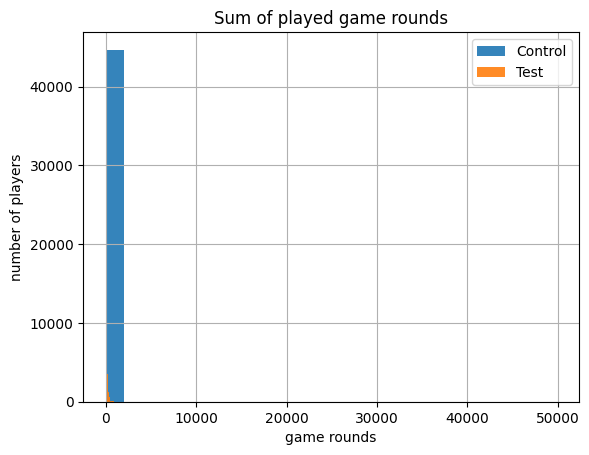

In [10]:
data['sum_gamerounds'][data['version'] == 'gate_30'].hist(bins = 25, alpha =0.9, label='Control')
data['sum_gamerounds'][data['version'] == 'gate_40'].hist(bins = 25, alpha =0.9, label='Test')
plt.title('Sum of played game rounds')
plt.xlabel('game rounds')
plt.ylabel('number of players')
plt.legend();

_Для проверки на нормальность будем использовать тест Колмогорова-Смирнова, т.к. выборка размером более 5000_

In [11]:
from scipy.stats import kstest

kstest(data[data['version']=='gate_40']['sum_gamerounds'].values, data[data['version']=='gate_30']['sum_gamerounds'].values, 'norm')

KstestResult(statistic=0.010270735856046653, pvalue=0.017070040502866063, statistic_location=22, statistic_sign=1)

И тест и гистограмма показывают, что распределение не нормально.

__*Для оценки sum_gamerounds применим критерий Манна-Уитни*__

In [12]:
from scipy.stats import mannwhitneyu

mw_stats = mannwhitneyu(x=data[(data['version'] == 'gate_30')]['sum_gamerounds'].values,
                                                  y=data[(data['version'] == 'gate_40')]['sum_gamerounds'].values)
mw_stats

MannwhitneyuResult(statistic=1024331250.5, pvalue=0.05020880772044255)

По сумме прохождения игровых раундов между группами нет статистически значимых различий (p-value > 0.05).

__*Для проверки retention будем использовать z-критерий*__

_Рассчитаем для retention_1_

In [13]:
control = data.query("version == 'gate_30'")
test = data.query("version == 'gate_40'")

n_control = control.shape[0]
n_test = test.shape[0]

conv_control = control['retention_1'].sum()
conv_test = test['retention_1'].sum()

In [14]:
from statsmodels.stats.proportion import proportions_ztest

z_stat, p_value = proportions_ztest([conv_control, conv_test], [n_control, n_test])

print(f"Z-statistic: {z_stat:.2f}\nP-value: {p_value:.4f}")

Z-statistic: 1.78
P-value: 0.0744


По retention_1 между группами нет статистически значимых различий (p-value > 0.05).

_Рассчитаем для retention_7_

In [15]:
conv_control = control['retention_7'].sum()
conv_test = test['retention_7'].sum()

In [16]:
z_stat, p_value = proportions_ztest([conv_control, conv_test], [n_control, n_test])

print(f"Z-statistic: {z_stat:.2f}\nP-value: {p_value:.4f}")

Z-statistic: 3.16
P-value: 0.0016


По retention_7 между группами есть статистически значимые различия (p-value < 0.05).

__*Для контроля также рассчитаем мощность теста*__

In [17]:
import numpy as np
import statsmodels.stats.power as smp

In [18]:
C_mean = control.retention_7.values.mean()
T_mean = test.retention_7.values.mean()

C_std = control.retention_7.values.std()
T_std = test.retention_7.values.std()

In [19]:
n =  len(control.retention_7.values)

In [20]:
##S = np.sqrt((sd_t**2 / n_t) + (sd_c**2 / n_c))

S = np.sqrt((T_std**2 + C_std **2)/ 2)

In [21]:
ef =float((T_mean-C_mean)/ S) 

In [22]:
# parameters for power analysis
alpha = 0.05

# perform power analysis
power = smp.zt_ind_solve_power(effect_size=ef, nobs1=n, alpha=alpha, alternative='two-sided')
power

0.8830917611540544

Moщность теста для retention_7 составила 88,3% - что вполне достачно.

### Итог

__*По результатам тестов можно сказать что альтернативная/тестовая версия более предпочтительна для привлечения игроков на более длительный срок.*__